# DataSet Performance

This notebook shows the tradeoffs between inserting data into the database row by row and as binary blobs.
There is a tradeoff between inserting the data in these to ways. 


Inserting the data row by row means that we direct access to all the data and may perform querys directly on the values of the data. On the other hand as we will see below this is much slower than inserting the data direcly as binary blobs

In [1]:
%matplotlib notebook
from collections import OrderedDict
from typing import Dict, Callable
from inspect import signature
import numpy.random as rd
import matplotlib.pyplot as plt
import json
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station
from qcodes.instrument.parameter import ManualParameter
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_shaped_data_by_runid
import time
# import logging
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [2]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#8@c:\Users\jenielse\mymainfolder\experiments.db
----------------------------------------------------------------------

Here we define a simple function to benchmark the time it takes to insert n points with either numeric or array data type.
We will compare both the time used to call add_result and the time used for the full measurement.

In [52]:
def insert_data(paramtype, npoints, nreps=1):

    meas = Measurement()

    x1 = ManualParameter('x1')
    x2 = ManualParameter('x2')
    x3 = ManualParameter('x3')
    y1 = ManualParameter('y1')
    y2 = ManualParameter('y2')

    meas.register_parameter(x1, paramtype=paramtype)
    meas.register_parameter(x2, paramtype=paramtype)
    meas.register_parameter(x3, paramtype=paramtype)
    meas.register_parameter(y1, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    meas.register_parameter(y2, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    start = time.perf_counter()
    with meas.run() as datasaver:
        start_adding = time.perf_counter()
        for i in range(nreps):
            datasaver.add_result((x1, np.random.rand(npoints)),
                                 (x2, np.random.rand(npoints)),
                                 (x3, np.random.rand(npoints)),
                                 (y1, np.random.rand(npoints)),
                                 (y2, np.random.rand(npoints)))
        stop_adding = time.perf_counter()
    stop = time.perf_counter()
    tot_time = stop - start
    add_time = stop_adding - start_adding
    return tot_time, add_time

And perform a quick comparison of the two 

In [54]:
sizes = [1,10,100,5000,10000]
t_numeric = []
t_numeric_add = []
t_array = []
t_array_add = []
for size in sizes:
    tn, tna =  insert_data('numeric', size)
    t_numeric.append(tn)
    t_numeric_add.append(tna)

    ta, taa =  insert_data('array', size)
    t_array.append(ta)
    t_array_add.append(taa)

Starting experimental run with id: 310
Starting experimental run with id: 311
Starting experimental run with id: 312
Starting experimental run with id: 313
Starting experimental run with id: 314
Starting experimental run with id: 315
Starting experimental run with id: 316
Starting experimental run with id: 317
Starting experimental run with id: 318
Starting experimental run with id: 319


<IPython.core.display.Javascript object>


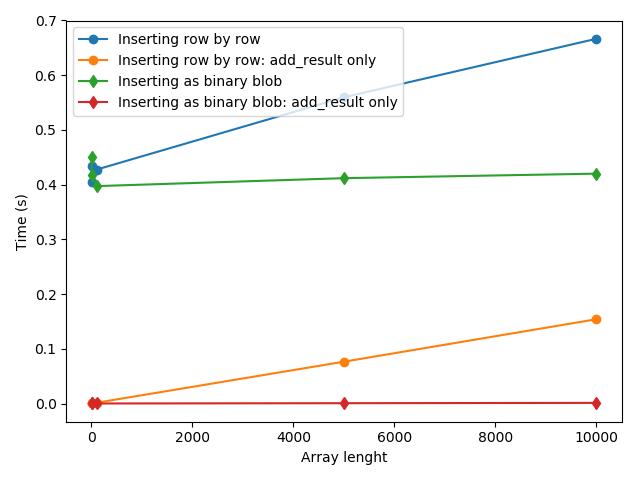

In [55]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row by row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row by row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array lenght')
ax.set_ylabel('Time (s)')
fig.tight_layout()

As we can see there the time to setup and and close the experiment is approximately 0.4 sec. At small array sizes the difference between inserting as arrays and inserting row by row is therefore relatively unimportant

In [56]:
sizes = [1,10,100,5000,10000]
nreps = 100
t_numeric = []
t_numeric_add = []
t_array = []
t_array_add = []
for size in sizes:
    tn, tna =  insert_data('numeric', size, nreps=nreps)
    t_numeric.append(tn)
    t_numeric_add.append(tna)

    ta, taa =  insert_data('array', size, nreps=nreps)
    t_array.append(ta)
    t_array_add.append(taa)

Starting experimental run with id: 320
Starting experimental run with id: 321
Starting experimental run with id: 322
Starting experimental run with id: 323
Starting experimental run with id: 324
Starting experimental run with id: 325
Starting experimental run with id: 326
Starting experimental run with id: 327
Starting experimental run with id: 328
Starting experimental run with id: 329


<IPython.core.display.Javascript object>


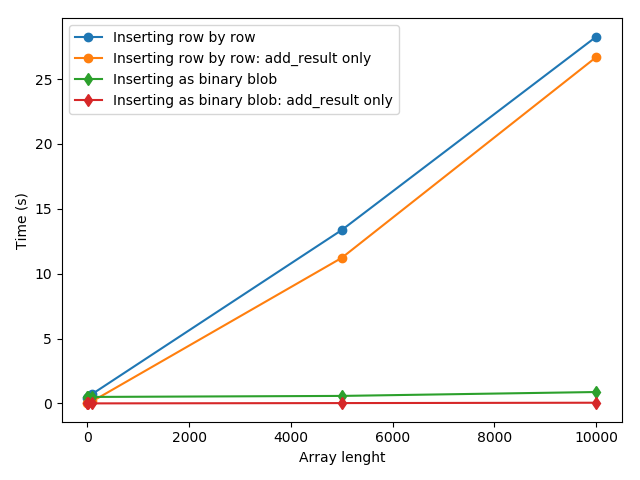

In [57]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row by row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row by row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array lenght')
ax.set_ylabel('Time (s)')
fig.tight_layout()

However, as we increase the length of the experimenter as seen here by repeating the insertion 100 times we see a big difference between inserting row by row and inserting as a binary blob